In [1]:
def problem1(file):
    #import pandas,numpy,datetime library
    import pandas as pd
    import numpy as np
    import datetime
    #read csv file and create dataframe
    df = pd.read_csv(file,encoding="latin-1") 
    #keep top-10 Complaint Type count
    TopComplaintType=df.groupby("Complaint Type").size().nlargest(10).index
    #convert Created and Closed Date to datetime
    df['Created Date'] = pd.to_datetime((df['Created Date']))
    df['Closed Date'] = pd.to_datetime((df['Closed Date']))
    #Difference between Closed and Created Date
    df['closing_time_hours'] = df['Closed Date'] - df['Created Date']
    #Convert closing time to hour
    df['closing_time_hours'] = df['closing_time_hours']/np.timedelta64(1,'h')
    #filter dataframe by status is Closed
    df = df[df['Status'] == 'Closed']
    #set display format for precision
    pd.options.display.float_format = '{:,.2f}'.format
    #pivot complaint type columns and calculate mean and count group by closing time
    metrics=df.pivot_table("closing_time_hours",index="Complaint Type",aggfunc=["mean","count"])
    #filter top-10 most frequent complaints.
    MetricsWithTop10 = round(metrics.loc[TopComplaintType],2)
    #Display with sort by ascending Complaint Type
    display(MetricsWithTop10.sort_values(by="Complaint Type",ascending=True).style)
    
def problem2(file):
    #import pandas,numpy,datetime library
    import pandas as pd
    import numpy as np
    import datetime
    import calendar
    #read csv file and create dataframe
    df = pd.read_csv(file,encoding="latin-1")
    #keep top-10 Complaint Type count
    count=df.groupby("Complaint Type").size().nlargest(10)
    top10=df.groupby("Complaint Type").size().nlargest(10).index.sort_values(ascending=True)
    #set display format for precision
    pd.options.display.float_format = '{:,.2f}'.format

    #find maximum created date in dataframe
    max_create_date = df.groupby("Created Date")["Created Date"].size().nlargest(1)
    #find value of maximum created date in dataframe
    max_create_date = pd.to_datetime(max_create_date.index.any())
    #Convert max_create_date to format month - day - string of day
    max_create_date_str = max_create_date.strftime('%B-%d-%A')
    #display date
    display(max_create_date_str)
    #Add new column to dataframe converted created date
    df['day'] = pd.to_datetime(df["Created Date"])
    #Convert create_date to format day - month - year
    df['day'] = pd.to_datetime(df['day'],format='%d/%m/%Y')
    #Keep day name of created dates
    df['day'] = df['day'].dt.day_name()
    #group by day and count complaint type according to top 10 complaint types
    df2 = df.groupby('day')['Complaint Type'].value_counts().unstack()[top10].style
    #group by complaint type and count according to Status with fill null with zeros , select top-10s
    df3 = df.groupby('Complaint Type')['Status'].value_counts().unstack().fillna(0).loc[top10]
    #remove columns which have zero values
    df3=df3.loc[:, (df3 != 0).any(axis=0)]
    #find percentage for the status of Complaints
    for i in df3.index:
        for k in count.index:
            if i == k:
                df3.loc[i] = round((df3.loc[i]/count.loc[k])*100,2)
    pd.options.display.float_format = '{:,.2f}'.format
    #Display for the number complaint type in each day of the week.
    display(df2)
    #Display the percentages for the status of Complaints
    display(df3.style)
    
def problem3(file):
    #import pandas,numpy,datetime library
    import pandas as pd
    import numpy as np
    import datetime
    #read csv file and create dataframe
    df = pd.read_csv(file,encoding="latin-1")
    #Convert Date column to datetime
    date = pd.to_datetime(df['Date'].values)
    #convert type year - name of month
    dateStr = date.strftime('%Y-%B')
    #convert date to year-month format
    date_month = date.strftime('%Y-%m')
    #add new column to dataframe keeping month of date for using groupby
    df['DateStr'] = date_month
    #create pivot table to count transaction number according to date and filter items coffee and tea
    metrics=df.pivot_table('Transaction',index=['DateStr'],columns='Item',aggfunc=lambda g: g.count()).filter(items=['Coffee', 'Tea'])
    #sort data and rename column
    metrics = metrics.reset_index().sort_values(by="DateStr",ascending=True).rename(columns={'DateStr':'Item'})
    #apply time format for all data
    metrics['Item'] = metrics.Item.map(lambda x:pd.to_datetime(x).strftime('%Y-%B'))
    #display pivot table
    metrics = metrics.set_index('Item')
    del metrics.index.name
    display(metrics.style)
    
def problem4(folder):
    #import pandas,numpy,os library
    import os
    import pandas as pd
    #take files under input folder
    entries = os.listdir(folder)
    #sort files
    entries.sort(reverse = True)
    #read csv files and create dataframes
    product_translation = pd.read_csv(os.path.join(folder, entries[0]),encoding="latin-1")
    sellers = pd.read_csv(os.path.join(folder, entries[1]),encoding="latin-1") 
    products = pd.read_csv(os.path.join(folder, entries[2]),encoding="latin-1") 
    orders = pd.read_csv(os.path.join(folder, entries[3]),encoding="latin-1") 
    order_reviews = pd.read_csv(os.path.join(folder, entries[4]),encoding="latin-1") 
    order_payments = pd.read_csv(os.path.join(folder, entries[5]),encoding="latin-1")
    order_items = pd.read_csv(os.path.join(folder, entries[6]),encoding="latin-1") 
    geolocation = pd.read_csv(os.path.join(folder, entries[7]),encoding="latin-1") 
    customers = pd.read_csv(os.path.join(folder, entries[8]),encoding="latin-1") 
    #merge all files and create dataframe
    data = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(order_items,products),product_translation),orders),sellers),customers)
    #group by seller_city and customer_city and count them 
    metrics = data.groupby(['seller_city', 'customer_city']).size().to_frame('count').reset_index()
    #do it again for other direction , group by customer_city and seller_city and count them 
    metrics2 = data.groupby(['customer_city', 'seller_city']).size().to_frame('count').reset_index()
    #outer join two dataframes and fill nan with zeros
    join_df_x = pd.merge(metrics, metrics2,  how='outer', left_on=['customer_city','seller_city'], right_on = ['seller_city','customer_city']).fillna(0)
    #remove rows which have same data
    join_df = join_df_x.query("customer_city_x != seller_city_x").copy()
    #for opposite pairs sum rows
    join_df['new_count'] = join_df.count_x + join_df.count_y
    #select necessary columns
    columns = ['customer_city_x','seller_city_x',"new_count"]
    #drop duplicates columns  and sort desceding
    final_df=join_df[columns].drop_duplicates('new_count').sort_values(by="new_count",ascending=False).reset_index()#.drop(0).drop(8)
    #select 10 rows
    final_df=(final_df.head(10))
    #add new column for index
    final_df['CustSell'] = '(' + final_df['customer_city_x'] + ',' + final_df['seller_city_x']+')'
    #rename column
    final_df = final_df.rename(columns={"new_count":"Total_orders"})
    #set index
    final_df = final_df.set_index(final_df['CustSell'].values)    
    #for presentation drop unnecesary columns
    final_df = final_df.drop(['index','customer_city_x','seller_city_x','CustSell'],axis=1)
    
    #display
    display(final_df.style)

def problem5(file):
    #import pandas,numpy,datetime,pyplot library
    import pandas as pd
    import numpy as np
    import datetime
    import matplotlib.pyplot as plt
    #read csv file and create dataframe
    df = pd.read_csv(file,encoding="latin-1")
    #drop unnecessary column and duplicates
    df = df.drop(['DataExtractDate'],axis=1).drop_duplicates()
    #convert Report period to datetime
    date = pd.to_datetime(df['ReportPeriod'].values)
    #extract year from date
    df['ReportPeriod'] = date.strftime('%Y')
    #For domestic international group report period and sum AirCargoTons
    domestic_data = df[df['Domestic_International'] == 'Domestic'].groupby('ReportPeriod')["AirCargoTons"].sum()
    #For international group report period and sum AirCargoTons
    international_data = df[df['Domestic_International'] == 'International'].groupby('ReportPeriod')["AirCargoTons"].sum()
    
    #take values of series
    domval= domestic_data.reset_index()['AirCargoTons'].values
    intval= international_data.reset_index()['AirCargoTons'].values
    #keep dates
    year = international_data.reset_index()['ReportPeriod'].values
    # create plot
    df = pd.DataFrame({'Domestic': domval, 'International': intval}, index=year)
    ax = df.plot.bar(rot=90).set(xlabel='ReportPeriod', ylabel='Tons')


A subset of the 311 service requests from NYC Open Data.
Finding average completion time in hours for top-10 most frequent complaints. 
Calculating how many data points you have for each complaint types for closed complaints.

In [3]:
problem1("/DATA/311-service-requests.csv")

,mean,count
,closing_time_hours,closing_time_hours
Complaint Type,,
Blocked Driveway,3,4581
DOF Literature Request,30.16,5486
GENERAL CONSTRUCTION,66.38,798
HEATING,54.88,6704
Illegal Parking,3.08,3336
NONCONST,65.54,416
PAINT - PLASTER,68.78,663
PLUMBING,65.84,764


A subset of the 311 service requests from NYC Open Data. 
Finding the day that has the highest number of complaints.
Producing a table for the number complaint type in each day of the week for the top-10 most frequent complaints
Finding the percentages for the status of Complaints for the top-10 most frequent complaints.

In [4]:
problem2("/DATA/311-service-requests.csv")

'October-24-Thursday'

Complaint Type,Blocked Driveway,DOF Literature Request,GENERAL CONSTRUCTION,HEATING,Illegal Parking,NONCONST,PAINT - PLASTER,PLUMBING,Street Condition,Street Light Condition
day,,,,,,,,,,
Friday,613,1035,963,2384,498,503,678,655,589,1467
Monday,720,1120,1425,1621,515,808,1059,1099,596,1203
Saturday,628,170,475,1596,395,263,319,333,166,197
Sunday,689,74,310,1316,422,245,207,301,286,203
Thursday,556,830,1121,2793,436,531,684,710,537,972
Tuesday,714,1288,1600,1809,537,893,1133,1120,663,1503
Wednesday,670,1280,1577,2681,540,755,1069,1155,636,1572


Status,Assigned,Closed,Open,Pending,Unassigned
Complaint Type,,,,,
Blocked Driveway,0.15,99.8,0.04,0,0
DOF Literature Request,1.19,94.64,4.14,0,0.03
GENERAL CONSTRUCTION,0,10.68,89.32,0,0
HEATING,0,47.21,52.79,0,0
Illegal Parking,0.09,99.79,0.12,0,0
NONCONST,0,10.41,89.59,0,0
PAINT - PLASTER,0,12.88,87.12,0,0
PLUMBING,0,14.22,85.78,0,0
Street Condition,6.97,75.15,13.62,4.26,0


BreadBasket_DMS.csv file that contains sales informations of a bakery.
The columns are: Date,Time,Transaction and Item. Transaction can be thought as the order id.
Producing a table showing the monthly sales quantity of coffee and Tea.

In [5]:
problem3("/DATA/BreadBasket_DMS.csv")

Item,Coffee,Tea
2016-October,93,31
2016-November,1189,311
2016-December,932,235
2017-January,892,260
2017-February,1004,267
2017-March,1071,258
2017-April,290,73


Brazilian ecommerce public dataset of orders of Olist Store. Go to following link and download the dataset. https://www.kaggle.com/olistbr/brazilian-ecommerce. 
Finding the economic interaction between cities. 
Finding the total number of orders between cities. 
Economic interaction between city pair "sao paulo" and "rio de janeiro" is the sum of number of orders which "sao paulo" as the customer city and "rio de janeiro" as the seller city, and the opposite.
After calculating economic interaction for each city pair return the top-10 cities having the highest interactions in terms of the number of total orders.

In [6]:
problem4("/DATA/brazilian-ecommerce/")

,Total_orders
"(sao paulo,rio de janeiro)",1951
"(sao paulo,ibitinga)",1342
"(sao paulo,belo horizonte)",967
"(sao paulo,curitiba)",825
"(sao paulo,santo andre)",718
"(sao paulo,guarulhos)",686
"(sao paulo,brasilia)",658
"(sao paulo,campinas)",645
"(rio de janeiro,ibitinga)",603
"(sao paulo,sao bernardo do campo)",533


los-angeles-international-airport-air-cargo-volume.csv
Go to following link and download the dataset. 
https://www.kaggle.com/cityofLA/los-angeles-international-airport-data. 
The file shows monthly tons of cargo that moved in and out through the Airport.
Ploting the yearly domestic and international cargo tons in a bar plot.

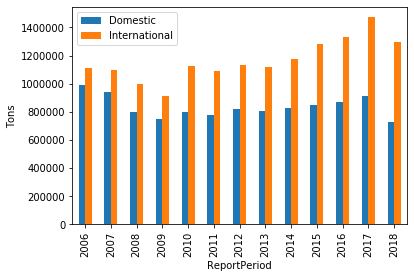

In [7]:
problem5("/DATA/los-angeles-international-airport-air-cargo-volume.csv")